# day 16 - Probabilistic Programming

# Demo 1: Hello world for linear regression in PyMC3

This is meant to be a first notebook for exploring how to use PyMC3 to do:

* MAP estimation
* MCMC sampling using the No-U-Turn (NUTS) extension of Hamlitonian Monte Carlo

Meant to allow side-by-side comparison with Stan in the parallel second demo notebook

Inspired by:

* Bob Carpenter's blog post:

https://statmodeling.stat.columbia.edu/2017/05/31/compare-stan-pymc3-edward-hello-world/

* The "hello world" example in the PyMC3 journal article:

Salvatier, Wiecki, and Fonnesbeck. "Probabilistic programming in Python using PyMC3". 
https://peerj.com/articles/cs-55.pdf

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid');
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

%matplotlib inline

# Import PyMC3


If you need to install it first, using the `spr_2021s_env` conda environment just do:

```console
$ conda activate spr_2021s_env
$ conda install -c conda-forge pymc3
```

In [3]:
import pymc3

# Model as MATH

We wish to consider a simple linear regression model.

Each individual example (indexed by $n$) has an output real value $y_n$. We model each observation as (conditionally) iid using a regression given two input features/covariates $x_{n1}$ and $x_{n2}$.

### Likelihood

\begin{align}
 p(y_{1:N} | x_{1:N}, \alpha, \beta, \sigma) &= \prod_{n=1}^N \text{NormPDF}(y_n | \alpha + \beta_1 x_{n1} + \beta_2 x_{n2}, \sigma^2)
\end{align}

We can identify the 3 scalar parameters that define our mean prediction: intercept $\alpha$, and weights $\beta_1$ and $\beta_2.

There is further the variance parameter $\sigma^2$.

### Priors on the variance of the likelihood:

\begin{align}
 p(\sigma) &= \text{HalfNormalPDF}(\sigma | 0, 1) = 
 \begin{cases}
     2 \cdot \text{NormalPDF}(\sigma | 0, 1) & \sigma > 0
\\
     0.0  & \sigma \leq 0
 \end{cases}
\end{align}

It is sometimes tough to find the right distribution to express our beliefs about the variance, which needs to be positive ($\sigma^2 > 0$). Here, we use the ``half-normal'' distribution, which is basically the half of the standard normal PDF that covers positive values, renormalized to be a valid pdf.

### Priors on regression coefficients:
\begin{align}
 p(\alpha) &= \text{NormalPDF}(0, 10)
\\
 p(\beta_1) &= \text{NormalPDF}(0, 10)
\\
 p(\beta_2) &= \text{NormalPDF}(0, 10)
\\    
\end{align}

# Simulate data from the model


In [4]:
# Initialize random number generator
np.random.seed(123)

# True regression coefficients
alpha = 1.0
beta = np.asarray([1.0, 1.337])

# True regression std dev
sigma = 0.3

# Size of dataset
N = 100

# Data Features (input variable)
x1_N = np.random.randn(N)
x2_N = np.random.randn(N)
x_N2 = np.hstack([x1_N[:,np.newaxis], x2_N[:,np.newaxis]])

# Simulate outcome variable
y_N = alpha + beta[0]*x1_N + beta[1]*x2_N + np.random.randn(N) * sigma

true_params = dict(
    alpha=alpha,
    beta=beta,
    sigma=sigma)

# Plot of observed data

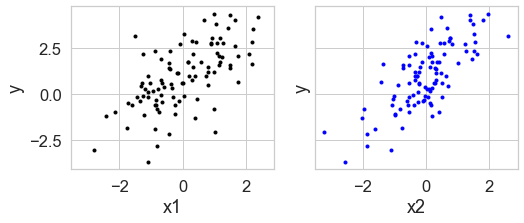

In [5]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(8,3), sharex=True, sharey=True);

axgrid[0].plot(x1_N, y_N, 'k.'); axgrid[0].set_xlabel('x1'); axgrid[0].set_ylabel('y');
axgrid[1].plot(x2_N, y_N, 'b.'); axgrid[1].set_xlabel('x2'); axgrid[1].set_ylabel('y');

# Model specified as a PyMC3 object

For the N=10 smaller dataset

In [6]:
my_model_N10 = pymc3.Model()

with my_model_N10:
    # Priors for unknown model parameters
    alpha = pymc3.Normal('alpha', mu=0, sd=10)
    beta = pymc3.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pymc3.HalfNormal('sigma', sd=1)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pymc3.Normal('Y_obs',
        mu=(alpha + beta[0] * x1_N[:10] + beta[1] * x2_N[:10]),
        sd=sigma,
        observed=y_N[:10])

For the N=100 bigger dataset

In [7]:
my_model_N100 = pymc3.Model()

with my_model_N100:
    # Priors for unknown model parameters
    alpha = pymc3.Normal('alpha', mu=0, sd=10)
    beta = pymc3.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pymc3.HalfNormal('sigma', sd=1)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pymc3.Normal('Y_obs',
        mu=(alpha + beta[0] * x1_N + beta[1] * x2_N),
        sd=sigma,
        observed=y_N)

In [8]:
print(my_model_N100.basic_RVs)

[alpha, beta, sigma_log__, Y_obs]


# Setup: Prepare for plotting results

In [9]:
def plot_traces(fit):
    fig, ax_grid = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True);
    for ax, var_name, dim in zip(
            ax_grid.flatten(), ['alpha', 'sigma', 'beta', 'beta'], [None, None, 0, 1]):
        var_samples_S = fit[var_name]
        true_val = true_params[var_name]

        if dim is not None:
            var_samples_S = var_samples_S[:, dim]
            true_val = true_val[dim]
            var_name = var_name + "[%d]" % dim

        S = var_samples_S.size
        ax.plot(var_samples_S, 'b.', markersize=4, alpha=0.3, label='samples')
        ax.plot(true_val * np.ones(S), 'r-', label='true_value')
        ax.set_ylabel(var_name)

    ax.legend(bbox_to_anchor=(1.1, 1.0))
    ax.set_ylim([0, 2.0]);

# Run MAP estimator for N=10 dataset

In [10]:
map_N10 = pymc3.find_MAP(model=my_model_N10, maxeval=1000)

/Users/mhughes/miniconda3/envs/spr_2020s_env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -8.0697, ||grad|| = 0.71175: 100%|██████████| 28/28 [00:00<00:00, 1470.97it/s]  


In [11]:
for key, arr in map_N10.items():
    print(key, arr)

alpha 1.069344037625922
beta [1.00373515 1.44519906]
sigma_log__ -1.607230117606145
sigma 0.2004420467603088


# Run MAP estimator for N=100 dataset

In [12]:
map_N100 = pymc3.find_MAP(model=my_model_N100, maxeval=1000)

/Users/mhughes/miniconda3/envs/spr_2020s_env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -28.138, ||grad|| = 0.0017975: 100%|██████████| 22/22 [00:00<00:00, 2242.40it/s]  


In [13]:
for key, arr in map_N100.items():
    print(key, arr)

alpha 0.9720043305924299
beta [0.98456717 1.34380165]
sigma_log__ -1.237493384514688
sigma 0.290110502779077


In [14]:
for key, arr in true_params.items():
    print(key, arr)

alpha 1.0
beta [1.    1.337]
sigma 0.3


# Run MCMC sampler for N=10 dataset

In [15]:
with my_model_N10:
    start = map_N10
    
    # instantiate sampler
    mcmc_step = pymc3.NUTS(scaling=start)
    
    # draw 1000 posterior samples
    trace = pymc3.sample(
        1000, mcmc_step, start=start, chains=1, tune=500, discard_tuned_samples=True)
    

Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|██████████| 1500/1500 [00:01<00:00, 1190.53it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


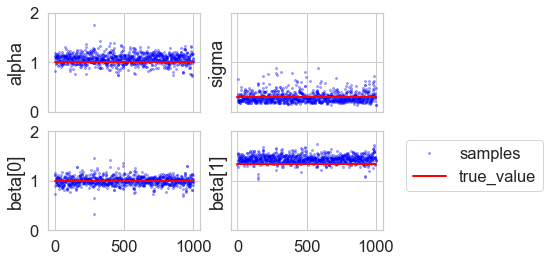

In [16]:
plot_traces(trace)

# Run MCMC sampler for N=100 dataset

In [17]:
with my_model_N100:
    start = map_N10
    
    # instantiate sampler
    mcmc_step = pymc3.NUTS(scaling=start)
    
    # draw 1000 posterior samples
    trace_N100 = pymc3.sample(
        1000, mcmc_step, start=start, chains=1, tune=500, discard_tuned_samples=True)

Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|██████████| 1500/1500 [00:00<00:00, 1598.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


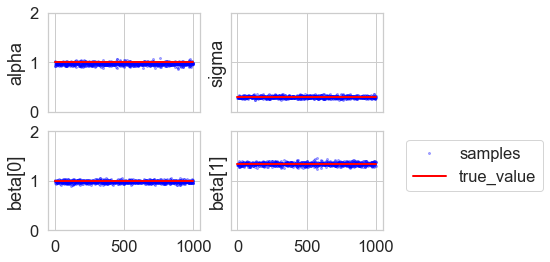

In [18]:
plot_traces(trace_N100)